## generate image with random PWM values

The original PWM randomly set by [3924, 1590, 961, 3237, 1230].


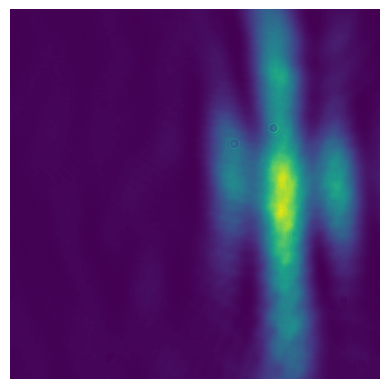

In [61]:
import csv
import numpy as np
import random
import time
from PIL import Image
from imageio import imwrite,imread
import os
from pylablib.devices import Thorlabs
from PIL import Image
import PIL.ImageOps 
import matplotlib.pyplot as plt 
  
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
cam.set_exposure(0.0001) # set exposure to 100ms
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

import laserbeamsize as lbs
A = np.random.randint(low=0,high=4095,size=(5,1), dtype=np.int32)   # range form 0 to 3000
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A)
raw_image_array = cam.grab(10) # grab 10 frames
image_array_initial=np.array(raw_image_array)
squeezed_image_array=image_array_initial.squeeze()
random_PWM=A
random_PWM_printed=A.ravel().tolist()
print(f"The original PWM randomly set by {random_PWM_printed}.")
plt.axis('off')
plt.imshow(image_array_initial[0])
cam.close()


In [62]:
time.sleep(0.1) # wait for 0.1 second and then reset the mirror by annealing
# Annealing
with open('PWM_test.csv', 'r', encoding='utf-8') as pwm_file:
    pwm_data = pwm_file.readlines()
# Write data to do_annealing.csv
with open('do_annealing.csv', 'w', encoding='utf-8') as annealing_file:
    annealing_file.writelines(pwm_data)
time.sleep(0.5)

In [63]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score
from PIL import Image
import glob

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)
def get_quality_number1(squeezed_image_array):
    score=[]
    for i in range (len(squeezed_image_array)):
        x=np.linspace(0,1000,1000)
        [m,n]=np.where(squeezed_image_array[i]==np.max(squeezed_image_array[i]))
        mode_info_m = stats.mode(m, keepdims=True)  ##col
        mode_info_n = stats.mode(n, keepdims=True) ##row
        a=int(mode_info_m[0])
        b=int(mode_info_n[0])
        c=5 #box half-thickness
        y_x=0

        for j in range (a-c,a+c):
            y_x=y_x+squeezed_image_array[i][j,:]/100 #tricky here since if this number is >255 it becomes 0.
        y_x=(y_x)/c*100

        y_y=0

        for j in range (b-c,b+c):
            y_y=y_y+squeezed_image_array[i][:,j]/100
        y_y=((y_y)/c)*100

        popt_x, pcov_x = optimize.curve_fit(gaussian, x, y_x+1,maxfev=500000) # tricky here!!!!! y_x+1
        fitted_y_x=popt_x[0] * np.exp(-((x - popt_x[1]) / 4 / popt_x[2])**2)
        a_x=r2_score(y_x,fitted_y_x)
        popt_y, pcov_y = optimize.curve_fit(gaussian, x, y_y+1,maxfev=500000) # same here!!!! y_y+1
        fitted_y_y=popt_y[0] * np.exp(-((x - popt_y[1]) / 4 / popt_y[2])**2)
        a_y=r2_score(y_y,fitted_y_y)

        s=abs(a_x*a_y)
        score.append(s)
        average_score=np.mean(score)
    return average_score

s1=get_quality_number1(squeezed_image_array)
print(s1)
time.sleep(0.1) # wait for 0.1 second and then reset the mirror by annealing
# Annealing
with open('PWM_test.csv', 'r', encoding='utf-8') as pwm_file:
    pwm_data = pwm_file.readlines()
# Write data to do_annealing.csv
with open('do_annealing.csv', 'w', encoding='utf-8') as annealing_file:
    annealing_file.writelines(pwm_data)
time.sleep(0.5)

0.6960922134484914


## Benchmark Loop

1. Compare Random to BO
2. Save results for evaluation

pip --no-cache-dir install botorch --user


In [64]:
def set_PWMs(pwms):
    # Your code that sets the PWMs
    A = np.array([[pwms[0]], [pwms[1]], [pwms[2]], [pwms[3]], [pwms[4]]]).astype(int)
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    return 0

In [65]:
set_PWMs([2809,1905,184,2093,4062])

0

In [66]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score
from PIL import Image
import glob
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
# cam.close()
cam.set_exposure(0.0001) # set exposure to 100ms
# frame = cam.snap() # grab a single frame
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)

In [12]:
def do_annealing(wait=5*33*0.03):
    # Annealing
    with open('PWM_test.csv', 'r', encoding='utf-8') as pwm_file:
        pwm_data = pwm_file.readlines()
    # Write data to do_annealing.csv
    with open('do_annealing.csv', 'w', encoding='utf-8') as annealing_file:
        annealing_file.writelines(pwm_data)
    time.sleep(wait) # Wait for annealing to complete

In [34]:
do_annealing()

In [32]:
def get_quality():

    #take image and calculate the quality number
    raw_image_array = cam.grab(10)    # grab 10 frame
    image_array=np.array(raw_image_array)
    squeezed_image_array=image_array.squeeze()
    score=[]
    for i in range (len(squeezed_image_array)):
        x=np.linspace(0,1000,1000)
        [m,n]=np.where(squeezed_image_array[i]==np.max(squeezed_image_array[i]))
        mode_info_m = stats.mode(m, keepdims=True)  ##col
        mode_info_n = stats.mode(n, keepdims=True) ##row
        a=int(mode_info_m[0])
        b=int(mode_info_n[0])
        c=5 #box half-thickness
        y_x=0

        for j in range (max(0,a-c),min(999,a+c)):
            y_x=y_x+squeezed_image_array[i][j,:]/100 #tricky here since if this number is >255 it becomes 0.
        y_x=(y_x)/c*100

        y_y=0

        for j in range (max(0,b-c),min(999,b+c)):
            y_y=y_y+squeezed_image_array[i][:,j]/100
        y_y=((y_y)/c)*100

        popt_x, pcov_x = optimize.curve_fit(gaussian, x, y_x+1,maxfev=500000) # tricky here!!!!! y_x+1
        fitted_y_x=popt_x[0] * np.exp(-((x - popt_x[1]) / 4 / popt_x[2])**2)
        a_x=r2_score(y_x,fitted_y_x)
        popt_y, pcov_y = optimize.curve_fit(gaussian, x, y_y+1,maxfev=500000) # same here!!!! y_y+1
        fitted_y_y=popt_y[0] * np.exp(-((x - popt_y[1]) / 4 / popt_y[2])**2)
        a_y=r2_score(y_y,fitted_y_y)

        s=abs(a_x*a_y)
        score.append(s)
        average_score=np.mean(score)
        quality_number = average_score
       
    return quality_number

In [80]:
import laserbeamsize as lbs

def get_quality_number2():
    #take image and calculate the quality number
    raw_image_array = cam.grab(10)    # grab 10 frame
    image_array=np.array(raw_image_array)
    squeezed_image_array=image_array.squeeze()
    score=[]
    for i in range (len(squeezed_image_array)):
        x, y, dx, dy, phi = lbs.beam_size(squeezed_image_array[i])
        denominator = max(dx, dy)
        if denominator == 0 :
            denominator = denominator + 0.000001
        Ellipticity = min(dx, dy) / denominator
        threshold_up_area = (squeezed_image_array[i] >= np.max(squeezed_image_array[i]) / 10) + 0  # define a threshold area
        total_pixel = squeezed_image_array[i].shape[0] * squeezed_image_array[i].shape[1]
        dispersion = total_pixel / np.sum(threshold_up_area)
        quality_number = dispersion * Ellipticity
        score.append(quality_number)
        average_score=np.mean(score)
    return average_score
s2=get_quality_number2()
print(s2)

8.970973015060512


In [81]:
get_quality()

0.8807005044058913

In [82]:
# SYNTHESIS and CHARACTERISATION
from OptimizationTestFunctions import Sphere, plot_3d
def set_PWMs_and_get_quality(pwms,sphere_test=False, annealing=False):
    if sphere_test:
        f = Sphere(dim=5,degree=2)
        #return -1*f(pwms)
        return -1*f(pwms)/1000000
    else:
        # Zoe fills in above:
        set_PWMs(pwms)
        quality_number = get_quality_number2()
        if annealing:
            do_annealing()
        return quality_number

In [22]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

In [23]:
# Random Strategy

import random

def get_random_PWMs():
    return [random.randint(0, 4095) for _ in range(5)]

random_PWMs = get_random_PWMs()
print(random_PWMs)

[1010, 3389, 2465, 672, 2509]


In [24]:
# Bayesian Opt Strategy

import numpy as np
import pandas as pd

from botorch.acquisition import qExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler

sampler = SobolQMCNormalSampler(sample_shape=torch.Size([512]), seed=0)
torch.manual_seed(seed=0)  # to keep the restart conditions the same    

def calculate_BO_candidate(samples):
    train_X = samples[["p1","p2","p3","p4","p5"]]
    train_Y = samples[["error"]]

    train_X = torch.tensor(train_X.to_numpy(dtype=np.float64))
    train_Y = torch.tensor(train_Y.to_numpy(dtype=np.float64))

    gp = SingleTaskGP(train_X, train_Y, input_transform=Normalize(d=train_X.shape[-1]), outcome_transform=Standardize(m=train_Y.shape[-1]),)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    #from botorch.acquisition import UpperConfidenceBound
    #UCB = UpperConfidenceBound(gp, beta=.1)

    MC_EI = qExpectedImprovement(gp, best_f=train_Y.max(), sampler=sampler)
    
    
    from botorch.optim import optimize_acqf
    bounds = torch.stack([torch.zeros(5), torch.ones(5)*4095])
    #bounds = torch.stack([torch.zeros(5), torch.ones(5)*5])

    candidate, acq_value = optimize_acqf(
        MC_EI, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    candidate = candidate[0]
    return candidate

Optimisation Loop:

In [83]:
import random
import pandas as pd
import time

N_TRIALS = 15
N_ITERATIONS = 250
USE_TEST_FUNCTION = False

best_random_all = []
best_BO_all = []
random_trial_samples = []
BO_trial_samples = []



for trial in range(N_TRIALS):
    print(f"Trial {trial}")
    BO_samples = pd.DataFrame(columns=['p1', 'p2', 'p3', "p4", "p5", 'error', 'trial', "iteration", "timestamp"])
    random_samples = pd.DataFrame(columns=['p1', 'p2', 'p3', "p4", "p5", 'error', 'trial', "iteration", "timestamp"])
    BO_current_candidate = get_random_PWMs()
    random_current_candidate = get_random_PWMs()
    
    best_random = []
    best_BO = []

    for iteration in range(N_ITERATIONS):
        
        #print(f"Iteration {iteration}")
        # Random Search
        random_current_quality = set_PWMs_and_get_quality(random_current_candidate, sphere_test=USE_TEST_FUNCTION)
        new_sample = {f"p{i+1}": p for i, p in enumerate(random_current_candidate)}
        new_sample["error"] = random_current_quality
        new_sample["timestamp"] = time.time()
        new_sample["trial"] = trial
        new_sample["iteration"] = iteration
        new_sample = pd.DataFrame(new_sample, index=[iteration])
        random_samples = pd.concat([random_samples, new_sample], axis=0, ignore_index=True)
        random_current_candidate = get_random_PWMs()
        
        # Bayesian Optimization
        BO_current_quality = set_PWMs_and_get_quality(BO_current_candidate, sphere_test=USE_TEST_FUNCTION)
        new_sample = {f"p{i+1}": p for i, p in enumerate(BO_current_candidate)}
        new_sample["error"] = BO_current_quality
        new_sample["timestamp"] = time.time()
        new_sample["trial"] = trial
        new_sample["iteration"] = iteration
        new_sample = pd.DataFrame(new_sample, index=[iteration])
        BO_samples = pd.concat([BO_samples, new_sample], axis=0, ignore_index=True)
        
        if iteration < 10:
            BO_current_candidate = get_random_PWMs()
        else:
            BO_current_candidate = calculate_BO_candidate(BO_samples)
            BO_current_candidate = [torch.round(x) for x in BO_current_candidate]
        
        best_random.append(random_samples["error"].max())
        best_BO.append(BO_samples["error"].max())
        
    random_trial_samples.append(random_samples.copy(deep=True))
    BO_trial_samples.append(BO_samples.copy(deep=True))
    
    best_random_all.append(best_random)
    best_BO_all.append(best_BO)

    # Print the best BO parameters and value for the current trial
    best_BO_value = max(best_BO)
    best_BO_index = best_BO.index(best_BO_value)
    best_BO_params = BO_trial_samples[trial].loc[best_BO_index, ['p1', 'p2', 'p3', 'p4', 'p5']].tolist()
    print(f"Best BO Parameters (Trial {trial}):", best_BO_params)
    print(f"Best BO Value (Trial {trial}):", best_BO_value)
    print("=" * 30)
import pickle
# open a file, where you ant to store the data
filename = 'results_'+str(time.time())
file = open(filename, 'wb')

# dump information to that file
data = (random_trial_samples, BO_trial_samples, best_random_all, best_BO_all)
pickle.dump(data, file)
# close the file
file.close()



Trial 0


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 0): [tensor(2674.), tensor(817.), tensor(138.), tensor(464.), tensor(3286.)]
Best BO Value (Trial 0): 23.60923623117177
Trial 1


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 1): [tensor(1359.), tensor(34.), tensor(3518.), tensor(3369.), tensor(3049.)]
Best BO Value (Trial 1): 23.395571332321204
Trial 2


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 2): [tensor(3603.), tensor(3732.), tensor(4065.), tensor(3650.), tensor(88.)]
Best BO Value (Trial 2): 22.93028316039072
Trial 3


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 3): [tensor(3207.), tensor(912.), tensor(3873.), tensor(1659.), tensor(899.)]
Best BO Value (Trial 3): 50.3866891661024
Trial 4


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializ

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Best BO Parameters (Trial 4): [tensor(2020.), tensor(2558.), tensor(2473.), tensor(2272.), tensor(1021.)]
Best BO Value (Trial 4): 25.978003031765866
Trial 5


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 5): [tensor(3416.), tensor(3878.), tensor(1171.), tensor(1607.), tensor(1203.)]
Best BO Value (Trial 5): 26.032007313379573
Trial 6


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 6): [tensor(1635.), tensor(4055.), tensor(46.), tensor(622.), tensor(443.)]
Best BO Value (Trial 6): 24.943002224668135
Trial 7


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 7): [tensor(3465.), tensor(1030.), tensor(4079.), tensor(1774.), tensor(1842.)]
Best BO Value (Trial 7): 25.82418816166608
Trial 8


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 8): [tensor(849.), tensor(1900.), tensor(2243.), tensor(2554.), tensor(1222.)]
Best BO Value (Trial 8): 23.449266638031975
Trial 9


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 9): [tensor(112.), tensor(1693.), tensor(3353.), tensor(3.), tensor(1928.)]
Best BO Value (Trial 9): 29.47409332743565
Trial 10


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 10): [tensor(2328.), tensor(3063.), tensor(2357.), tensor(3860.), tensor(2322.)]
Best BO Value (Trial 10): 22.956060257207447
Trial 11


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializ

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 11): [tensor(3626.), tensor(910.), tensor(3872.), tensor(2618.), tensor(4000.)]
Best BO Value (Trial 11): 26.388678362832856
Trial 12


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 12): [tensor(909.), tensor(235.), tensor(1392.), tensor(1278.), tensor(274.)]
Best BO Value (Trial 12): 26.784375443491797
Trial 13


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 13): [tensor(1205.), tensor(1975.), tensor(544.), tensor(1675.), tensor(3954.)]
Best BO Value (Trial 13): 31.240596148295282
Trial 14


C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\AppData\Roaming\Python\Python310\site-packages\botorch\optim\initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
C:\Users\plasma\

Best BO Parameters (Trial 14): [tensor(3444.), tensor(2810.), tensor(1153.), tensor(2512.), tensor(3781.)]
Best BO Value (Trial 14): 23.94385405308776


In [70]:
BO_trial_samples

[     p1    p2    p3    p4    p5    error trial iteration     timestamp
 0  2841   355  3992  2379  1343  3.75256     0         0  1.692121e+09
 1   956  1846   988   127  3769  4.20117     0         1  1.692121e+09,
      p1    p2    p3    p4    p5     error trial iteration     timestamp
 0  3790  1074  3454  2715  2747  4.773538     1         0  1.692121e+09
 1  2254   867  1102  3758  2219  3.091864     1         1  1.692121e+09]

In [71]:
best_BO_all

[[3.7525599312433315, 4.201169793803697],
 [4.773538188787262, 4.773538188787262]]

## Plot results

In [72]:
filename

'results_1692120599.5083723'

In [73]:
# open a file, where you stored the pickled data
file = open(filename, 'rb')

# dump information to that file
data = pickle.load(file)
random_trial_samples, BO_trial_samples, best_random_all, best_BO_all = data

# close the file
file.close()

print('Showing the pickled data:')

cnt = 0
for item in data:
    print('The data ', cnt, ' is : ', item)
    cnt += 1


Showing the pickled data:
The data  0  is :  [     p1    p2    p3    p4    p5     error trial iteration     timestamp
0  2316  1591   735  1640  4050  2.579028     0         0  1.692121e+09
1  1343  2588  2124  3192   518  3.609907     0         1  1.692121e+09,      p1    p2    p3    p4   p5     error trial iteration     timestamp
0  3990  1037   786  1909  303  6.817912     1         0  1.692121e+09
1   404  1348  1109  3197  310  2.024823     1         1  1.692121e+09]
The data  1  is :  [     p1    p2    p3    p4    p5    error trial iteration     timestamp
0  2841   355  3992  2379  1343  3.75256     0         0  1.692121e+09
1   956  1846   988   127  3769  4.20117     0         1  1.692121e+09,      p1    p2    p3    p4    p5     error trial iteration     timestamp
0  3790  1074  3454  2715  2747  4.773538     1         0  1.692121e+09
1  2254   867  1102  3758  2219  3.091864     1         1  1.692121e+09]
The data  2  is :  [[2.579027509218901, 3.6099071826650615], [6.81791232

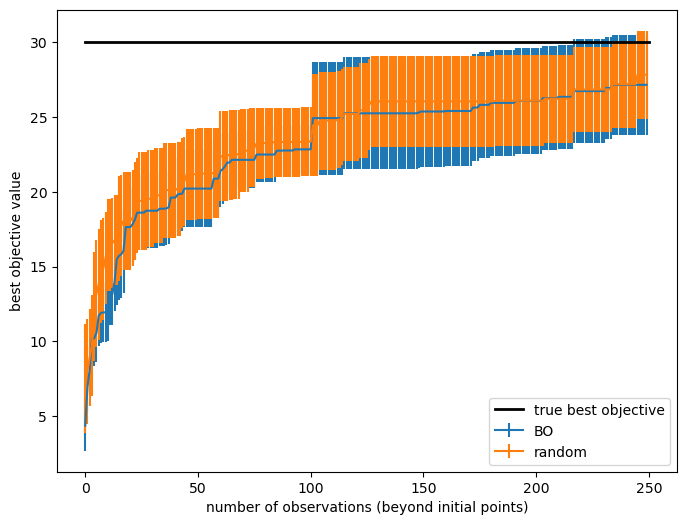

In [86]:
import numpy as np
from matplotlib import pyplot as plt


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

GLOBAL_MAXIMUM = 30
if USE_TEST_FUNCTION:
    GLOBAL_MAXIUM = 0



iters = np.arange(N_ITERATIONS)
y_random = np.asarray(best_random_all)
y_BO = np.asarray(best_BO_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.errorbar(iters, y_BO.mean(axis=0), yerr=ci(y_BO), label="BO", linewidth=1.5)
ax.errorbar(iters, y_random.mean(axis=0), yerr=ci(y_random), label="random", linewidth=1.5)
plt.plot(
    [0, N_ITERATIONS],
    [GLOBAL_MAXIMUM] * 2,
    "k",
    label="true best objective",
    linewidth=2,
)
#ax.set_ylim(bottom=0.5)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="best objective value",
)
ax.legend(loc="lower right")

In [87]:
y_BO

array([[ 3.31667772,  8.31654899,  8.31654899, ..., 23.60923623,
        23.60923623, 23.60923623],
       [ 1.58193366, 11.03148083, 11.03148083, ..., 23.39557133,
        23.39557133, 23.39557133],
       [ 1.78742442,  1.78742442,  3.01981263, ..., 22.93028316,
        22.93028316, 22.93028316],
       ...,
       [14.17909461, 14.17909461, 14.17909461, ..., 26.78437544,
        26.78437544, 26.78437544],
       [ 7.1919685 ,  7.1919685 ,  7.1919685 , ..., 31.24059615,
        31.24059615, 31.24059615],
       [ 3.1800265 ,  5.46404582,  5.46404582, ..., 23.94385405,
        23.94385405, 23.94385405]])

In [ ]:
y_random

In [ ]:
cam.close()

In [50]:
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
cam.set_exposure(0.0001) # set exposure to 100ms
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

import laserbeamsize as lbs
A0 = np.array([[random_PWM[0]], [random_PWM[1]], [random_PWM[2]], [random_PWM[3]], [random_PWM[4]]])
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A0)
print(f"The original PWM randomly set by {random_PWM_printed} with score {s1}")

optimal_pwm_values=best_BO_params
A1= np.array([[optimal_pwm_values[0]], [optimal_pwm_values[1]], [optimal_pwm_values[2]], [optimal_pwm_values[3]], [optimal_pwm_values[4]]])
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A1)
raw_image_array1 = cam.grab(10) # grab 10 frames
image_array1=np.array(raw_image_array1)
squeezed_image_array1=image_array1.squeeze()
print(f"The suggested PWM values for correction is {optimal_pwm_values} with score {best_BO_value}")
cam.close()

The original PWM randomly set by [831, 285, 1233, 2384, 788] with score 0.9740964525258118
The suggested PWM values for correction is [1358, 3701, 317, 906, 1953] with score 23.872924484805782


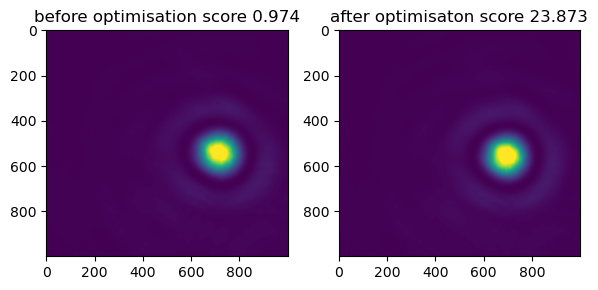

In [51]:
rows = 1
columns = 2
fig, (ax1, ax2) = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))
ax1.imshow(image_array_initial[0], aspect='auto')
ax1.set_title(f'before optimisation score {s1:.3f}')
ax2.imshow(image_array1[0], aspect='auto')
ax2.set_title(f'after optimisaton score {best_BO_value:.3f}')
fig.tight_layout() # used to adjust padding between subplots 

In [56]:
cam.close()

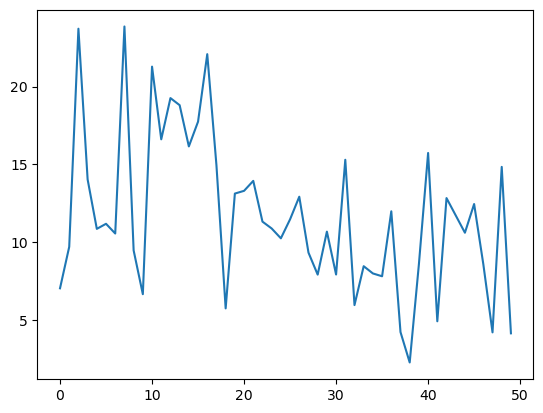

In [53]:
plt.plot(BO_trial_samples[0]["error"])